<a href="https://colab.research.google.com/github/athabrani/BTCUSD-Scraper/blob/main/Big_Data_Dataset_Kelompok_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Model

In [3]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=486240f8d4622cbc69b60e3d4211db7e6e7bf5624e70f8dae35f0e93b938e9ea
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, QuantileTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import ta
from sklearn.linear_model import LinearRegression, RidgeCV, ElasticNetCV, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, silhouette_score
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

In [5]:
from google.colab import drive
drive.mount('/content/drive')
url = '/content/drive/MyDrive/Big Data Dataset/btc_4h_merged.csv'
df = pd.read_csv(url)

Mounted at /content/drive


In [ ]:
df

,Timestamp,Open,High,Low,Close,Volume
0,2012-01-01 16:00:00,4.58,4.58,4.58,4.58,0.000000
1,2012-01-01 20:00:00,4.58,4.58,4.58,4.58,0.000000
2,2012-01-02 00:00:00,4.58,4.84,4.58,4.84,10.000000
3,2012-01-02 04:00:00,4.84,4.84,4.84,4.84,0.000000
4,2012-01-02 08:00:00,4.84,5.00,4.84,5.00,10.100000
...,...,...,...,...,...,...
30107,2025-11-07 03:00:00,101335.00,101576.00,100491.00,101284.00,552.119824
30108,2025-11-07 07:00:00,101288.00,102278.00,100695.00,101864.00,269.189701
30109,2025-11-07 11:00:00,101874.00,102463.00,101519.00,101962.00,131.772868
30110,2025-11-07 15:00:00,101961.00,101989.00,99765.00,100361.00,369.765280


##Data Cleaning

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30112 entries, 0 to 30111
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timestamp  30112 non-null  object 
 1   Open       30112 non-null  float64
 2   High       30112 non-null  float64
 3   Low        30112 non-null  float64
 4   Close      30112 non-null  float64
 5   Volume     30112 non-null  float64
dtypes: float64(5), object(1)
memory usage: 1.4+ MB


In [7]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
print(df.dtypes)

Timestamp    datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Volume              float64
dtype: object


In [8]:
df.isnull().sum()

,0
Timestamp,0
Open,0
High,0
Low,0
Close,0
Volume,0


In [9]:
df.dropna(inplace=True)

In [10]:
df.duplicated().sum()

np.int64(0)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30112 entries, 0 to 30111
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Timestamp  30112 non-null  datetime64[ns]
 1   Open       30112 non-null  float64       
 2   High       30112 non-null  float64       
 3   Low        30112 non-null  float64       
 4   Close      30112 non-null  float64       
 5   Volume     30112 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 1.4 MB


In [12]:
df.head(10)

,Timestamp,Open,High,Low,Close,Volume
0,2012-01-01 16:00:00,4.58,4.58,4.58,4.58,0.0
1,2012-01-01 20:00:00,4.58,4.58,4.58,4.58,0.0
2,2012-01-02 00:00:00,4.58,4.84,4.58,4.84,10.0
3,2012-01-02 04:00:00,4.84,4.84,4.84,4.84,0.0
4,2012-01-02 08:00:00,4.84,5.00,4.84,5.00,10.1
5,2012-01-02 12:00:00,5.00,5.00,5.00,5.00,0.0
6,2012-01-02 16:00:00,5.00,5.00,5.00,5.00,0.0
7,2012-01-02 20:00:00,5.00,5.00,5.00,5.00,0.0
8,2012-01-03 00:00:00,5.00,5.00,5.00,5.00,0.0
9,2012-01-03 04:00:00,5.00,5.00,5.00,5.00,0.0


In [13]:
num_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

In [14]:
outlier_summary = {}
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_summary[col] = len(outliers)

    print(f"Kolom {col}: {len(outliers)} outlier terdeteksi")

Kolom Open: 2198 outlier terdeteksi
Kolom High: 2200 outlier terdeteksi
Kolom Low: 2197 outlier terdeteksi
Kolom Close: 2199 outlier terdeteksi
Kolom Volume: 2311 outlier terdeteksi


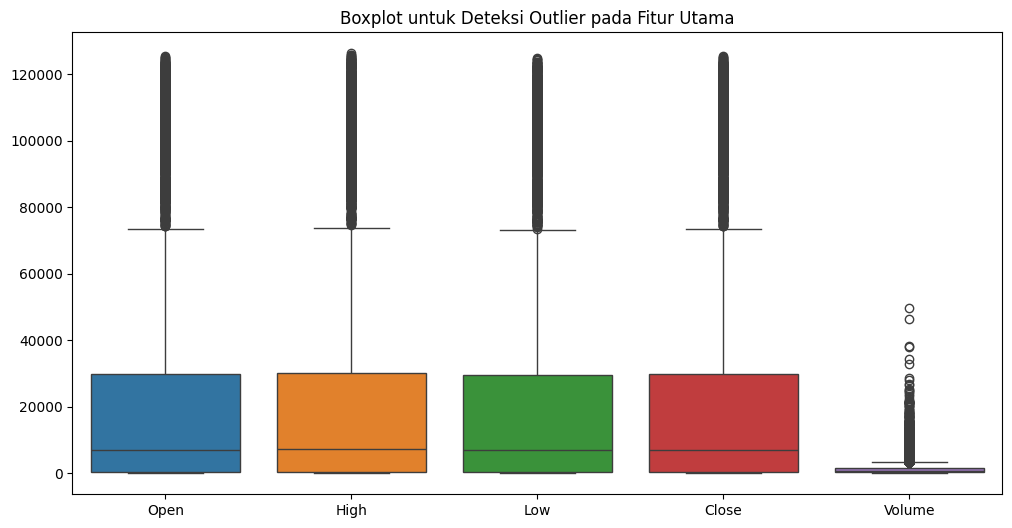

In [15]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[num_cols])
plt.title("Boxplot untuk Deteksi Outlier pada Fitur Utama")
plt.show()

In [16]:
num_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

In [17]:
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1
mask_iqr = ~((df[num_cols] < (Q1 - 1.5 * IQR)) | (df[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)

In [18]:
from scipy import stats
z_scores = np.abs(stats.zscore(df[num_cols]))
mask_z = (z_scores < 3).all(axis=1)

In [19]:
mask_final = mask_iqr & mask_z
df_clean = df[mask_final]

In [20]:
print(f"Jumlah data awal: {len(df)}")
print(f"Jumlah data setelah remove outlier: {len(df_clean)}")

Jumlah data awal: 30112
Jumlah data setelah remove outlier: 25601


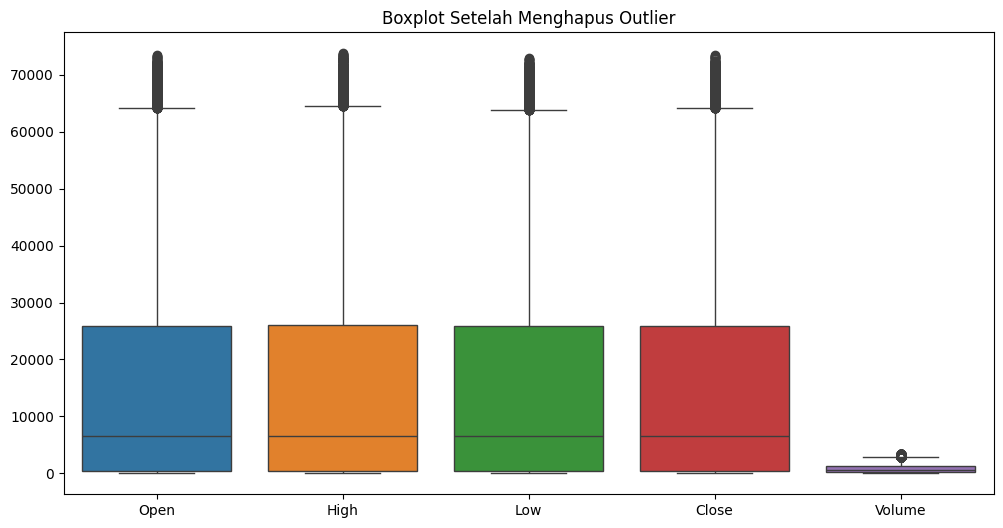

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clean[num_cols])
plt.title("Boxplot Setelah Menghapus Outlier")
plt.show()

In [22]:
df = df_clean.reset_index(drop=True)

In [23]:
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [24]:
THRESHOLD = 0.01

In [25]:
df['future_close'] = df['Close'].shift(-1)
df['future_pct_change'] = (df['future_close'] - df['Close']) / df['Close']

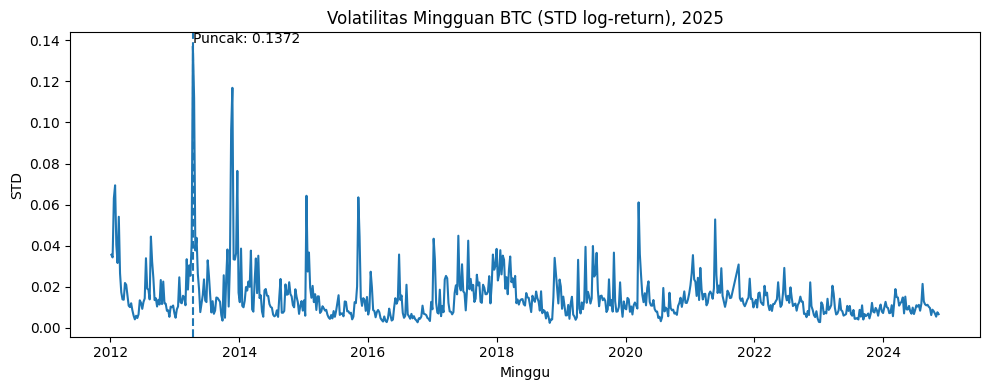

In [27]:
# === EDA (SMART Q1): Volatilitas Mingguan 2025 ===
df_eda = df.copy()
df_eda['Timestamp'] = pd.to_datetime(df_eda['Timestamp'], errors='coerce', utc=True)
df_eda = df_eda.sort_values('Timestamp')

df_eda['log_ret'] = np.log(df_eda['Close']).diff()

vol_week = (df_eda
            .set_index('Timestamp')['log_ret']
            .resample('W').std()
            .dropna())


peak_week = vol_week.idxmax()
peak_val  = vol_week.max()

plt.figure(figsize=(10,4))
plt.plot(vol_week.index, vol_week.values)
plt.title('Volatilitas Mingguan BTC (STD log-return), 2025')
plt.axvline(peak_week, linestyle='--')
plt.text(peak_week, peak_val, f'Puncak: {peak_val:.4f}', va='bottom')
plt.ylabel('STD'); plt.xlabel('Minggu'); plt.tight_layout(); plt.show()


##Klasifikasi

###Feature Engineering

In [44]:
def classify_target(change):
    if change > THRESHOLD:
        return 'Up'
    elif change < -THRESHOLD:
        return 'Down'
    else:
        return 'Neutral'

In [45]:
df['Target'] = df['future_pct_change'].apply(classify_target)

In [46]:
df.dropna(inplace=True)

In [47]:
df['sma_fast'] = ta.trend.sma_indicator(df['Close'], window=12)
df['sma_slow'] = ta.trend.sma_indicator(df['Close'], window=24)

In [48]:
df['rsi'] = ta.momentum.rsi(df['Close'], window=14)

In [49]:
macd = ta.trend.MACD(df['Close'], window_slow=26, window_fast=12, window_sign=9)
df['macd_diff'] = macd.macd_diff()

In [50]:
df['pct_change_1'] = df['Close'].pct_change(periods=1)

In [51]:
bollinger = ta.volatility.BollingerBands(df['Close'], window=20, window_dev=2)
df['bb_width'] = bollinger.bollinger_wband()
df['bb_percent'] = bollinger.bollinger_pband()
atr_indicator = ta.volatility.AverageTrueRange(df['High'], df['Low'], df['Close'], window=14)
df['atr'] = atr_indicator.average_true_range()

In [52]:
df['obv'] = ta.volume.on_balance_volume(df['Close'], df['Volume'])

In [53]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

### Data Preparation

In [ ]:
features = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'sma_fast', 'sma_slow', 'rsi', 'macd_diff', 'pct_change_1',
    'bb_width', 'bb_percent', 'atr', 'obv'
]
target = 'Target'

X = df[features]
y = df[target]

In [ ]:
split_percentage = 0.8
split_index = int(len(df) * split_percentage)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [ ]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

### Modeling RF

In [ ]:
rf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=50,
                            min_samples_leaf=20, random_state=42, n_jobs=-1)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test_scaled)

In [ ]:
y_pred_rf = rf.predict(X_test_scaled)
print("\n--- Hasil Random Forest ---")
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy RF: {acc_rf}")
print("\nClassification Report RF:\n", classification_report(y_test, y_pred_rf, target_names=le.classes_))


--- Hasil Random Forest ---
Accuracy RF: 0.4968701095461659

Classification Report RF:
               precision    recall  f1-score   support

        Down       0.13      0.50      0.20       474
     Neutral       0.88      0.53      0.66      4113
          Up       0.16      0.23      0.19       525

    accuracy                           0.50      5112
   macro avg       0.39      0.42      0.35      5112
weighted avg       0.73      0.50      0.57      5112



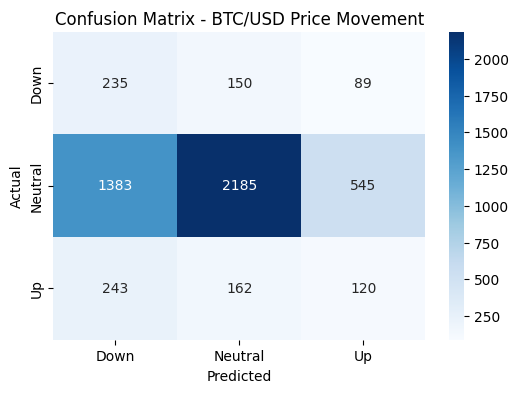

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - BTC/USD Price Movement")
plt.show()

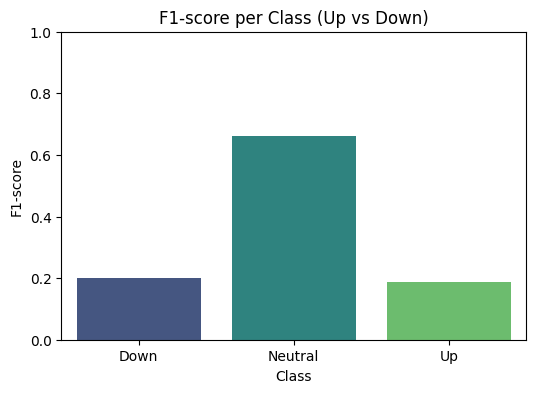

In [ ]:
report = classification_report(y_test, y_pred_rf, target_names=le.classes_, output_dict=True)
f1_scores = [report[label]['f1-score'] for label in le.classes_]

plt.figure(figsize=(6, 4))
sns.barplot(x=le.classes_, y=f1_scores, hue=le.classes_, palette='viridis', legend=False)
plt.title("F1-score per Class (Up vs Down)")
plt.xlabel("Class")
plt.ylabel("F1-score")
plt.ylim(0, 1)
plt.show()

### XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

xgb.fit(X_train_scaled, y_train_enc)
y_pred_xgb = xgb.predict(X_test_scaled)

acc_xgb = accuracy_score(y_test_enc, y_pred_xgb)
f1_xgb = classification_report(y_test_enc, y_pred_xgb, output_dict=True)['weighted avg']['f1-score']

print("XGBoost Accuracy:", acc_xgb)
print("XGBoost F1:", f1_xgb)


XGBoost Accuracy: 0.7965571205007824
XGBoost F1: 0.7220857089917725


### LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import class_weight

def create_sequences(X_data, y_data, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X_data) - time_steps):
        Xs.append(X_data[i:(i + time_steps)])
        ys.append(y_data[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 24
n_features = X_train_scaled.shape[1]

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_enc, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_enc, TIME_STEPS)

print(f"Bentuk X_train_seq (LSTM): {X_train_seq.shape}")
print(f"Bentuk y_train_seq (LSTM): {y_train_seq.shape}")
print(f"Bentuk X_test_seq (LSTM): {X_test_seq.shape}")
print(f"Bentuk y_test_seq (LSTM): {y_test_seq.shape}")
print(f"(Bentuknya harus: [samples, {TIME_STEPS}, {n_features}])")

lstm_model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(TIME_STEPS, n_features)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(len(le.classes_), activation='softmax')
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
lstm_model.summary()

weights = class_weight.compute_class_weight('balanced',
                                            classes=np.unique(y_train_seq),
                                            y=y_train_seq)
class_weights_dict = dict(enumerate(weights))

early_stop = EarlyStopping(monitor='val_loss', patience=10,restore_best_weights=True)

history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=64,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=[early_stop],
    verbose=1,
    class_weight=class_weights_dict
)

y_pred_probs = lstm_model.predict(X_test_seq)
y_pred_lstm = np.argmax(y_pred_probs, axis=1)

# Encode y_test to numerical labels before evaluation
acc_lstm = accuracy_score(y_test_seq, y_pred_lstm)
print(f"🎯 LSTM Accuracy: {acc_lstm}")
print(classification_report(y_test_seq, y_pred_lstm, target_names=le.classes_))

Bentuk X_train_seq (LSTM): (20423, 24, 14)
Bentuk y_train_seq (LSTM): (20423,)
Bentuk X_test_seq (LSTM): (5088, 24, 14)
Bentuk y_test_seq (LSTM): (5088,)
(Bentuknya harus: [samples, 24, 14])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 24, 256)        │       146,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,011 (1.20 MB)

 Trainable params: 315,011 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 64s 176ms/step - accuracy: 0.5182 - loss: 1.0582 - val_accuracy: 0.5393 - val_loss: 1.0385
Epoch 2/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 79s 168ms/step - accuracy: 0.5201 - loss: 1.0313 - val_accuracy: 0.2028 - val_loss: 1.1143
Epoch 3/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 55s 171ms/step - accuracy: 0.5213 - loss: 1.0296 - val_accuracy: 0.6268 - val_loss: 1.0097
Epoch 4/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 56s 175ms/step - accuracy: 0.5247 - loss: 1.0236 - val_accuracy: 0.4705 - val_loss: 1.0958
Epoch 5/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 82s 174ms/step - accuracy: 0.5157 - loss: 1.0327 - val_accuracy: 0.6044 - val_loss: 1.0317
Epoch 6/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 81s 174ms/step - accuracy: 0.5420 - loss: 1.0233 - val_accuracy: 0.7015 - val_loss: 0.9541
Epoch 7/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 54s 170ms/step - accuracy: 0.5448 - loss: 1.0152 - val_accuracy: 0.5635 - val_loss: 0.9825
Epoch 8/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 55s 173ms/step - accuracy: 0.5204 - loss: 1

In [ ]:
print(X_train_seq.shape, y_train_seq.shape)
print(np.unique(y_train_seq, return_counts=True))

(20423, 24, 14) (20423,)
(array([0, 1, 2]), array([ 2876, 14217,  3330]))


### Eval

/tmp/ipython-input-2945135269.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results, palette='cool')


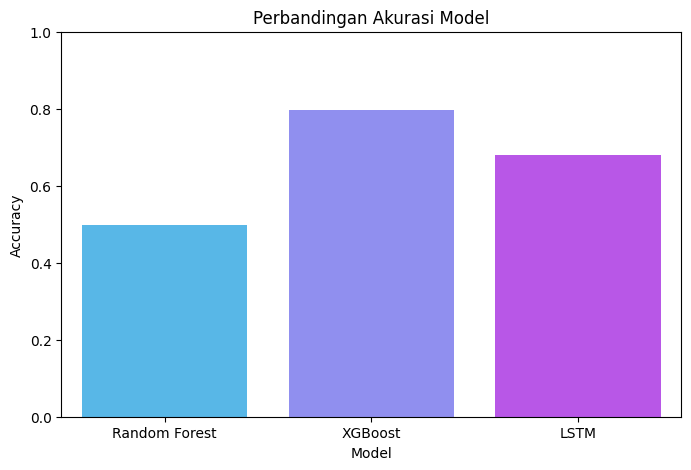

           Model  Accuracy  F1-score
0  Random Forest  0.496870  0.569857
1        XGBoost  0.796557  0.722086
2           LSTM  0.679442  0.689592


In [ ]:
report_rf = classification_report(y_test, y_pred_rf, target_names=le.classes_, output_dict=True)
f1_rf = report_rf['weighted avg']['f1-score']

report_lstm = classification_report(y_test_seq, y_pred_lstm, target_names=le.classes_, output_dict=True)
f1_lstm = report_lstm['weighted avg']['f1-score']

results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'LSTM'],
    'Accuracy': [acc_rf, acc_xgb, acc_lstm],
    'F1-score': [f1_rf, f1_xgb, f1_lstm]
})

plt.figure(figsize=(8,5))
sns.barplot(x='Model', y='Accuracy', data=results, palette='cool')
plt.title("Perbandingan Akurasi Model")
plt.ylim(0, 1)
plt.show()

print(results)

##Regresi

Pada bagian regresi, tujuan kami adalah memprediksi besaran perubahan harga berikutnya (future_pct_change) dari pasangan BTC/USDT berbasis data 4 jam. Untuk meningkatkan sinyal prediksi, kami menambahkan fitur time-series (lag returns, rolling mean/std, z-score, volatilitas return, momentum) di samping indikator teknikal (SMA, RSI, MACD, Bollinger, ATR, OBV). Pipeline memisahkan data training dan test secara time-based (80/20) untuk menghindari kebocoran informasi temporal, melakukan standardisasi fitur (StandardScaler), serta transformasi target dengan QuantileTransformer pada model linear agar lebih stabil terhadap distribusi return yang heavy-tailed.

###Feature Boost

time-series

In [ ]:
df_reg = df.copy()

In [ ]:
# lag returns
df_reg['pct_change_3']  = df_reg['Close'].pct_change(periods=3)
df_reg['pct_change_6']  = df_reg['Close'].pct_change(periods=6)
df_reg['pct_change_12'] = df_reg['Close'].pct_change(periods=12)

# Lag level price (z-score membantu model linear)
for lag in [1, 3, 6, 12]:
    df_reg[f'close_lag_{lag}'] = df_reg['Close'].shift(lag)

# Rolling stats (gunakan window pendek & menengah)
for w in [5, 10, 20]:
    df_reg[f'roll_mean_{w}'] = df_reg['Close'].rolling(w).mean()
    df_reg[f'roll_std_{w}']  = df_reg['Close'].rolling(w).std()
    df_reg[f'roll_z_{w}']    = (df_reg['Close'] - df_reg[f'roll_mean_{w}']) / (df_reg[f'roll_std_{w}'] + 1e-9)

# Volatility proxy berbasis return
for w in [5, 10, 20]:
    df_reg[f'ret_vol_{w}'] = df_reg['pct_change_1'].rolling(w).std()

# Momentum sederhana
for w in [5, 10, 20]:
    df_reg[f'mom_{w}'] = df_reg['Close'] / (df_reg['Close'].shift(w)) - 1

###Data Preparation

In [ ]:
base_features = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'sma_fast', 'sma_slow', 'rsi', 'macd_diff', 'pct_change_1',
    'bb_width', 'bb_percent', 'atr', 'obv'
]

extra_features = [
    'pct_change_3', 'pct_change_6', 'pct_change_12',
    'close_lag_1', 'close_lag_3', 'close_lag_6', 'close_lag_12',
    'roll_mean_5', 'roll_std_5', 'roll_z_5',
    'roll_mean_10', 'roll_std_10', 'roll_z_10',
    'roll_mean_20', 'roll_std_20', 'roll_z_20',
    'ret_vol_5', 'ret_vol_10', 'ret_vol_20',
    'mom_5', 'mom_10', 'mom_20'
]

reg_features = base_features + extra_features
reg_target   = 'future_pct_change'

In [ ]:
reg_df = df_reg.dropna(subset=reg_features + [reg_target]).copy()

In [ ]:
reg_split_pct = 0.8
reg_split_ix  = int(len(reg_df) * reg_split_pct)

Xr = reg_df[reg_features]
yr = reg_df[reg_target]

Xr_train = Xr.iloc[:reg_split_ix]
Xr_test  = Xr.iloc[reg_split_ix:]
yr_train = yr.iloc[:reg_split_ix]
yr_test  = yr.iloc[reg_split_ix:]



In [ ]:
scaler_reg = StandardScaler()
qt_reg     = QuantileTransformer(output_distribution='normal', random_state=42)

Xr_train_sc = scaler_reg.fit_transform(Xr_train)
Xr_test_sc  = scaler_reg.transform(Xr_test)


In [ ]:
yr_train_q = qt_reg.fit_transform(yr_train.values.reshape(-1,1)).ravel()
yr_test_q  = qt_reg.transform(yr_test.values.reshape(-1,1)).ravel()

###Validation Scheme

Untuk mengestimasi kinerja yang lebih realistis pada data berurutan, kami gunakan TimeSeriesSplit(n_splits=5) saat memilih hiperparameter di model linear (Ridge/ElasticNet) dan meta-learner. Skema ini menjaga urutan waktu (no shuffle) sehingga menghindari optimisme berlebih.

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

###Modeling Linear Regression

In [ ]:
linreg = LinearRegression()
linreg.fit(Xr_train_sc, yr_train)
yr_pred_lin = linreg.predict(Xr_test_sc)

###XGBoost Regressor

In [ ]:
gbr = GradientBoostingRegressor(
    n_estimators=600,
    learning_rate=0.02,
    max_depth=3,
    subsample=0.8,
    random_state=42
)

xgbr = XGBRegressor(
    n_estimators=800,
    max_depth=5,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=1e-3,
    random_state=42,
    objective='reg:squarederror'
)

###Regularized linear (Ridge)

In [ ]:
ridge = RidgeCV(alphas=np.logspace(-4, 3, 20), cv=tscv)
ela   = ElasticNetCV(l1_ratio=[.2,.5,.8,.9,.95,1.0], alphas=np.logspace(-4, 1, 20), cv=tscv, max_iter=10000)

###Robust Linear (HUber)

In [ ]:
huber = HuberRegressor(epsilon=1.35, alpha=1e-4, max_iter=500)

###Train

In [ ]:
# Linear models pakai target kuantil
ridge.fit(Xr_train_sc, yr_train_q)
ela.fit(Xr_train_sc, yr_train_q)
huber.fit(Xr_train_sc, yr_train_q)

# Tree-based pakai target asli
gbr.fit(Xr_train_sc, yr_train)
xgbr.fit(Xr_train_sc, yr_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.298064268383314, tolerance: 1.3283748050633326
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84.58976574881854, tolerance: 1.6030127898644637
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=800,
             n_jobs=None, num_parallel_tree=None, ...)

###Predict

In [ ]:
yr_pred_ridge_q = ridge.predict(Xr_test_sc).reshape(-1,1)
yr_pred_ela_q   = ela.predict(Xr_test_sc).reshape(-1,1)
yr_pred_huber_q = huber.predict(Xr_test_sc).reshape(-1,1)

yr_pred_ridge = qt_reg.inverse_transform(yr_pred_ridge_q).ravel()
yr_pred_ela   = qt_reg.inverse_transform(yr_pred_ela_q).ravel()
yr_pred_huber = qt_reg.inverse_transform(yr_pred_huber_q).ravel()

yr_pred_gbr   = gbr.predict(Xr_test_sc)
yr_pred_xgb   = xgbr.predict(Xr_test_sc)

###Stacking Ensemble

In [ ]:
base_preds_train = np.column_stack([
    ridge.predict(Xr_train_sc),
    gbr.predict(Xr_train_sc),
    xgbr.predict(Xr_train_sc)
])

# meta target utk linear = kuantil; gabungkan base prediksi (konversi yang perlu)
# gbr/xgb train pred masih di skala asli, kita ubah ke kuantil untuk meta yang linear
meta_y_train = yr_train_q
meta_X_train = np.column_stack([
    ridge.predict(Xr_train_sc),                         # kuantil
    qt_reg.transform(gbr.predict(Xr_train_sc).reshape(-1,1)).ravel(),   # -> kuantil
    qt_reg.transform(xgbr.predict(Xr_train_sc).reshape(-1,1)).ravel()   # -> kuantil
])

meta_ridge = RidgeCV(alphas=np.logspace(-4, 3, 20), cv=tscv)
meta_ridge.fit(meta_X_train, meta_y_train)

# Prediksi meta pada test
meta_X_test = np.column_stack([
    ridge.predict(Xr_test_sc),
    qt_reg.transform(yr_pred_gbr.reshape(-1,1)).ravel(),
    qt_reg.transform(yr_pred_xgb.reshape(-1,1)).ravel()
])
yr_pred_meta_q = meta_ridge.predict(meta_X_test).reshape(-1,1)
yr_pred_meta   = qt_reg.inverse_transform(yr_pred_meta_q).ravel()


###Eval

--- Linear Regression ---
MSE  : 0.000104
RMSE : 0.010198
R^2  : -0.0049
--- XGBoost ---
MSE  : 0.000109
RMSE : 0.010418
R^2  : -0.0489
--- Ridge(Q→orig) ---
MSE  : 0.000103
RMSE : 0.010167
R^2  : 0.0011
--- ElasticNet(Q→orig) ---
MSE  : 0.000103
RMSE : 0.010173
R^2  : -0.0000
--- Huber(Q→orig) ---
MSE  : 0.000104
RMSE : 0.010176
R^2  : -0.0006
--- GradientBoosting ---
MSE  : 0.000104
RMSE : 0.010204
R^2  : -0.0062
--- Stacking(Ridge+GBR+XGB) ---
MSE  : 0.000120
RMSE : 0.010954
R^2  : -0.1595

== Enhanced Regression Results ==
                     Model       MSE      RMSE       MAE        R2      Corr
2            Ridge(Q→orig)  0.000103  0.010167  0.006481  0.001122  0.045929
3       ElasticNet(Q→orig)  0.000103  0.010173  0.006487 -0.000028  0.000000
4            Huber(Q→orig)  0.000104  0.010176  0.006467 -0.000576  0.048184
0        Linear Regression  0.000104  0.010198  0.006587 -0.004906  0.068842
5         GradientBoosting  0.000104  0.010204  0.006533 -0.006247  0.024348
1    

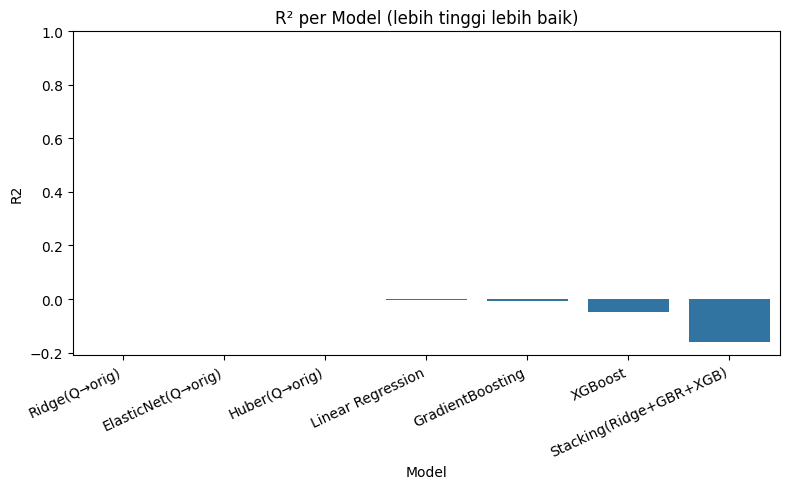


Scale check — y_test mean: 0.000281, std: 0.010173


In [ ]:
def eval_reg_all(y_true, y_pred, name="Model"):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"--- {name} ---")
    print(f"MSE  : {mse:.6f}")
    print(f"RMSE : {rmse:.6f}")
    print(f"R^2  : {r2:.4f}")
    corr = np.corrcoef(y_true, y_pred)[0,1] if np.std(y_pred)>0 else 0.0
    return {"Model": name, "MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "Corr": corr}


y_true = yr_test.values
rows = []
rows.append(eval_reg_all(y_true, yr_pred_lin,   "Linear Regression"))
rows.append(eval_reg_all(y_true, yr_pred_xgb,   "XGBoost"))
rows.append(eval_reg_all(y_true, yr_pred_ridge, "Ridge(Q→orig)"))
rows.append(eval_reg_all(y_true, yr_pred_ela,   "ElasticNet(Q→orig)"))
rows.append(eval_reg_all(y_true, yr_pred_huber, "Huber(Q→orig)"))
rows.append(eval_reg_all(y_true, yr_pred_gbr,   "GradientBoosting"))
rows.append(eval_reg_all(y_true, yr_pred_meta,  "Stacking(Ridge+GBR+XGB)"))

res_enh = pd.DataFrame(rows).sort_values("RMSE")
print("\n== Enhanced Regression Results ==")
print(res_enh)

# Plot perbandingan R2
plt.figure(figsize=(8,5))
sns.barplot(x='Model', y='R2', data=res_enh, order=res_enh.sort_values('R2', ascending=False)['Model'])
plt.title("R² per Model (lebih tinggi lebih baik)")
plt.xticks(rotation=25, ha='right')
plt.ylim(min(-0.2, res_enh['R2'].min()-0.05), 1.0)
plt.tight_layout()
plt.show()

# Skala target untuk konteks
print(f"\nScale check — y_test mean: {y_true.mean():.6f}, std: {y_true.std():.6f}")

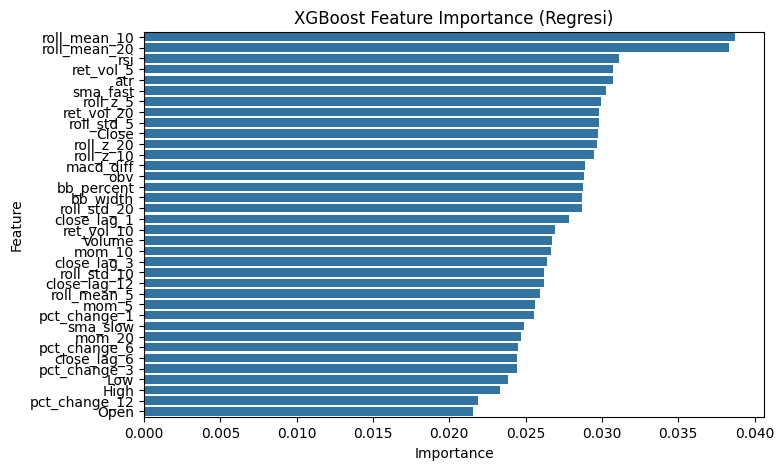

In [ ]:
imp = pd.Series(xgbr.feature_importances_, index=reg_features).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=imp.values, y=imp.index)
plt.title("XGBoost Feature Importance (Regresi)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [ ]:
y_true = yr_test.values
rmse_lin = np.sqrt(((y_true - yr_pred_lin)**2).mean())
rmse_xgb = np.sqrt(((y_true - yr_pred_xgb)**2).mean())
rmse_zero = np.sqrt((y_true**2).mean())
print(f"Std(y_test)   : {y_true.std():.6f}")
print(f"RMSE Zero(0)  : {rmse_zero:.6f}")
print(f"RMSE Linear   : {rmse_lin:.6f}")
print(f"RMSE XGB      : {rmse_xgb:.6f}")

Std(y_test)   : 0.010173
RMSE Zero(0)  : 0.010177
RMSE Linear   : 0.010198
RMSE XGB      : 0.010418


##Clustering

###Preprocessing

In [57]:
clus_features = ['pct_change_1', 'rsi', 'macd_diff', 'bb_width', 'bb_percent', 'atr', 'Volume']

In [58]:
clus_df = df.dropna(subset=clus_features + ['Timestamp', 'Close', 'future_pct_change']).copy()

In [59]:
scaler_clus = StandardScaler()
Xs = scaler_clus.fit_transform(clus_df[clus_features])

###K Optimal

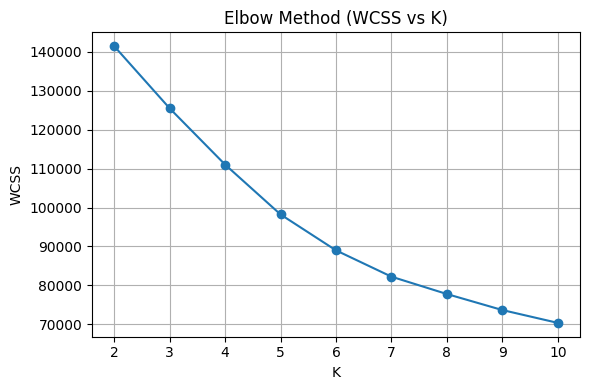

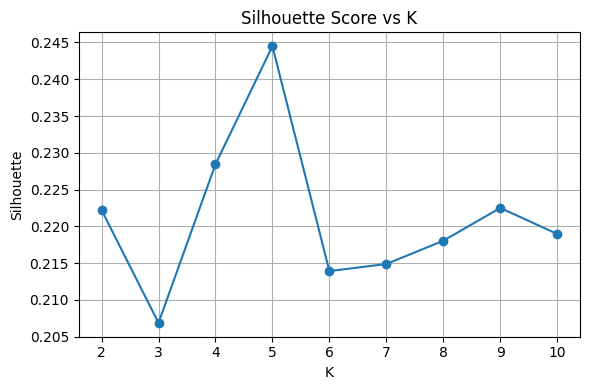

Best K (berdasarkan silhouette): 5


In [62]:
wcss, sil_scores, K_range = [], [], range(2, 11)  # dari 2 s/d 10 klaster
for k in K_range:
    km = KMeans(n_clusters=k, n_init=30, random_state=42)
    labels = km.fit_predict(Xs)
    wcss.append(km.inertia_)
    sil_scores.append(silhouette_score(Xs, labels))

# Plot Elbow
plt.figure(figsize=(6,4))
plt.plot(list(K_range), wcss, marker='o')
plt.title('Elbow Method (WCSS vs K)')
plt.xlabel('K'); plt.ylabel('WCSS'); plt.grid(True); plt.tight_layout()
plt.show()

# Plot Silhouette
plt.figure(figsize=(6,4))
plt.plot(list(K_range), sil_scores, marker='o')
plt.title('Silhouette Score vs K')
plt.xlabel('K'); plt.ylabel('Silhouette'); plt.grid(True); plt.tight_layout()
plt.show()

best_k = list(K_range)[int(np.argmax(sil_scores))]
print(f"Best K (berdasarkan silhouette): {best_k}")

###K Means

In [63]:
kmeans_final = KMeans(n_clusters=best_k, n_init=50, random_state=42)
labels_km = kmeans_final.fit_predict(Xs)
clus_df['cluster_km'] = labels_km

# Profil klaster K-Means
def cluster_profile(frame, label_col):
    # Mean fitur + future return, plus count
    prof = frame.groupby(label_col)[clus_features + ['future_pct_change']].mean().round(6)
    cnt  = frame[label_col].value_counts().sort_index()
    prof['count'] = cnt
    return prof

print("\n== Profil Klaster — K-Means ==")
km_profile = cluster_profile(clus_df, 'cluster_km')
print(km_profile)


== Profil Klaster — K-Means ==
            pct_change_1        rsi   macd_diff   bb_width  bb_percent  \
cluster_km                                                               
0               0.003178  61.170084  193.038147  10.849189    0.806048   
1               0.000388  52.112391   -0.271822   5.382379    0.549116   
2              -0.009316  36.488765  -18.190931  12.396310    0.142678   
3              -0.003128  40.944536 -203.814907  10.186892    0.195651   
4               0.010336  67.573924   16.981801  13.379207    0.898027   

                    atr       Volume  future_pct_change  count  
cluster_km                                                      
0           1024.760761   558.804401          -0.000393   2242  
1            145.429451   458.889895           0.000145  11717  
2            121.563456  1523.372954           0.000322   4561  
3           1050.653878   581.285136           0.000451   2115  
4            112.178019  1615.074900           0.002021   4

###DBScan

In [64]:
candidate_eps = [0.4, 0.6, 0.8, 1.0, 1.2]
candidate_min_samples = [5, 10, 20]

best_db = {"eps": None, "min_samples": None, "silhouette": -1, "labels": None}
for eps in candidate_eps:
    for ms in candidate_min_samples:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(Xs)
        # Hitung silhouette tanpa noise (-1); butuh >= 2 klaster valid
        mask_valid = labels != -1
        n_clusters = len(set(labels[mask_valid]))
        if n_clusters >= 2 and mask_valid.sum() > 10:
            sil = silhouette_score(Xs[mask_valid], labels[mask_valid])
            if sil > best_db["silhouette"]:
                best_db = {"eps": eps, "min_samples": ms, "silhouette": sil, "labels": labels}

if best_db["labels"] is None:
    print("\nDBSCAN: belum menemukan klaster stabil di grid awal; gunakan default eps=0.8, min_samples=10.")
    db = DBSCAN(eps=0.8, min_samples=10).fit(Xs)
    clus_df['cluster_db'] = db.labels_
else:
    print(f"\nDBSCAN terbaik: eps={best_db['eps']}, min_samples={best_db['min_samples']}, "
          f"silhouette_valid={best_db['silhouette']:.3f}")
    clus_df['cluster_db'] = best_db["labels"]

print("\n== Profil Klaster — DBSCAN (label -1 = noise) ==")
db_profile = cluster_profile(clus_df, 'cluster_db')
print(db_profile)


DBSCAN terbaik: eps=0.6, min_samples=20, silhouette_valid=0.417

== Profil Klaster — DBSCAN (label -1 = noise) ==
            pct_change_1        rsi   macd_diff   bb_width  bb_percent  \
cluster_db                                                               
-1              0.000942  51.722598   -0.050911  15.483415    0.521604   
 0              0.000309  52.377778    0.614708   5.994389    0.544671   
 1             -0.001070  41.730473 -315.128402   5.550241    0.066123   
 2              0.003744  45.638259 -275.412055   6.184531    0.217539   

                   atr       Volume  future_pct_change  count  
cluster_db                                                     
-1          565.188226  1303.642613           0.001124   8210  
 0          153.297064   694.249875           0.000224  17277  
 1          957.601741   237.451264           0.001959     21  
 2          996.595500   225.466100          -0.001020     18  


###Eval

In [65]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

metrics_rows = []

# KMeans (semua sampel)
labels_km = clus_df['cluster_km'].values
sil_km = silhouette_score(Xs, labels_km)
dbi_km = davies_bouldin_score(Xs, labels_km)
chi_km = calinski_harabasz_score(Xs, labels_km)
metrics_rows.append({
    "Model": "KMeans",
    "Silhouette": sil_km,
    "DaviesBouldin": dbi_km,
    "CalinskiHarabasz": chi_km,
    "NoiseRatio": np.nan
})

# DBSCAN (abaikan noise -1 untuk perhitungan internal metrics)
labels_db = clus_df['cluster_db'].values
mask_valid = labels_db != -1
if mask_valid.sum() > 0 and len(set(labels_db[mask_valid])) >= 2:
    sil_db  = silhouette_score(Xs[mask_valid], labels_db[mask_valid])
    dbi_db  = davies_bouldin_score(Xs[mask_valid], labels_db[mask_valid])
    chi_db  = calinski_harabasz_score(Xs[mask_valid], labels_db[mask_valid])
else:
    sil_db, dbi_db, chi_db = np.nan, np.nan, np.nan

noise_ratio = float((labels_db == -1).mean()) if len(labels_db) else np.nan
metrics_rows.append({
    "Model": "DBSCAN",
    "Silhouette": sil_db,
    "DaviesBouldin": dbi_db,
    "CalinskiHarabasz": chi_db,
    "NoiseRatio": noise_ratio
})

eval_clu = pd.DataFrame(metrics_rows)
print("\n== CLUSTERING INTERNAL METRICS ==")
print(eval_clu)


== CLUSTERING INTERNAL METRICS ==
    Model  Silhouette  DaviesBouldin  CalinskiHarabasz  NoiseRatio
0  KMeans    0.244672       1.338697       5227.654016         NaN
1  DBSCAN    0.417412       1.043400         97.030861    0.321633


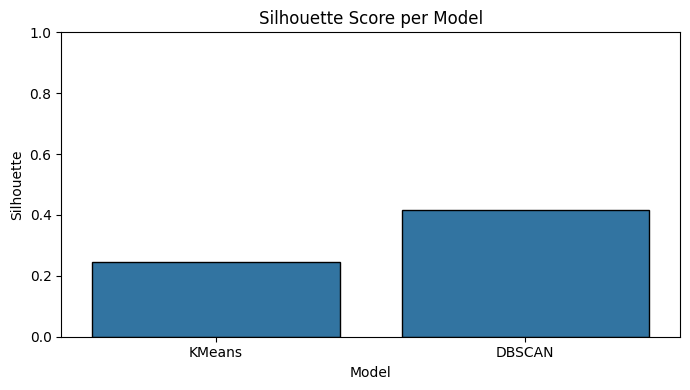

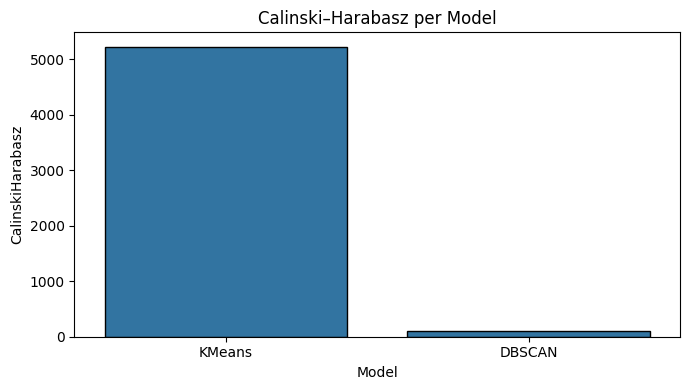

DBSCAN Noise Ratio: 32.16%


In [66]:
plt.figure(figsize=(7,4))
sns.barplot(x="Model", y="Silhouette", data=eval_clu, edgecolor="black")
plt.title("Silhouette Score per Model"); plt.ylim(0,1); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
sns.barplot(x="Model", y="CalinskiHarabasz", data=eval_clu, edgecolor="black")
plt.title("Calinski–Harabasz per Model"); plt.tight_layout(); plt.show()

if not np.isnan(eval_clu.loc[eval_clu["Model"]=="DBSCAN","NoiseRatio"]).all():
    nr = eval_clu.loc[eval_clu["Model"]=="DBSCAN","NoiseRatio"].values[0]
    print(f"DBSCAN Noise Ratio: {nr:.2%}")


####Visualisasi

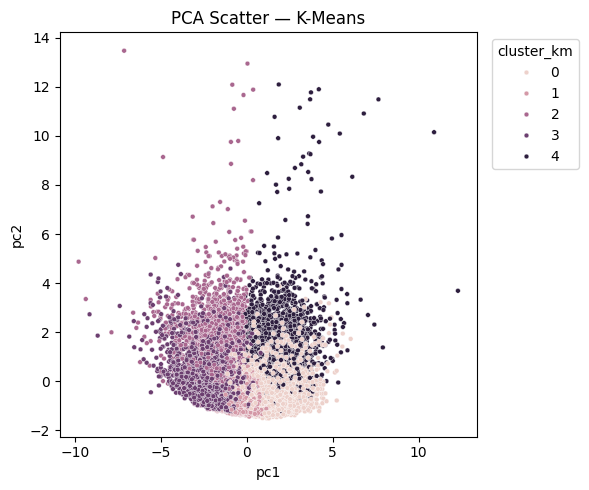

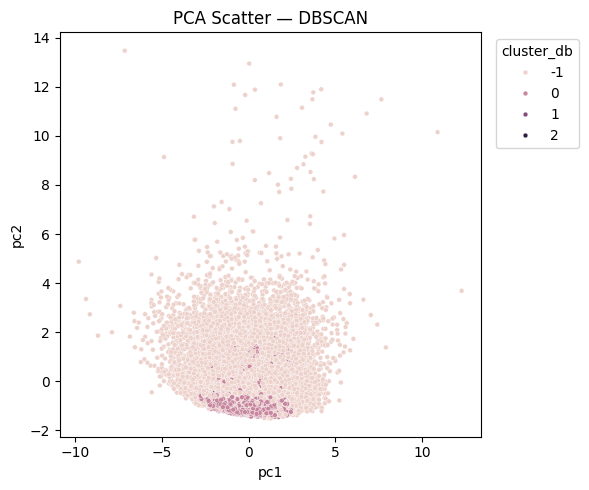

In [67]:
pca = PCA(n_components=2, random_state=42)
Xpca = pca.fit_transform(Xs)
viz_df = pd.DataFrame({
    'pc1': Xpca[:,0], 'pc2': Xpca[:,1],
    'cluster_km': clus_df['cluster_km'].values,
    'cluster_db': clus_df['cluster_db'].values
})

plt.figure(figsize=(6,5))
sns.scatterplot(data=viz_df, x='pc1', y='pc2', hue='cluster_km', s=12)
plt.title('PCA Scatter — K-Means'); plt.legend(title='cluster_km', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,5))
sns.scatterplot(data=viz_df, x='pc1', y='pc2', hue='cluster_db', s=12)
plt.title('PCA Scatter — DBSCAN'); plt.legend(title='cluster_db', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout(); plt.show()

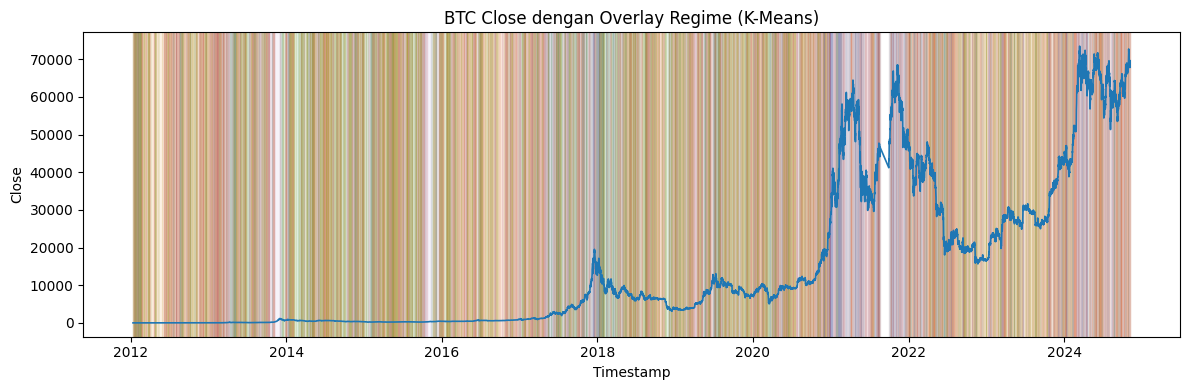

In [68]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(clus_df['Timestamp'], clus_df['Close'], linewidth=1.2)
ax.set_title("BTC Close dengan Overlay Regime (K-Means)")
ax.set_xlabel("Timestamp"); ax.set_ylabel("Close")


cmap = plt.get_cmap('tab10')
curr = None; start_idx = 0
times = clus_df['Timestamp'].values
labs  = clus_df['cluster_km'].values

for i in range(len(labs)):
    if curr is None:
        curr = labs[i]; start_idx = i
    if i == len(labs)-1 or labs[i+1] != curr:

        x0 = times[start_idx]; x1 = times[i]
        ax.axvspan(x0, x1, color=cmap(curr), alpha=0.08)
        curr = None

plt.tight_layout(); plt.show()


         pct_change_1      rsi  macd_diff  bb_width  bb_percent        atr  \
cluster                                                                      
0              0.0032  61.1701   193.0381   10.8492      0.8060  1024.7608   
1              0.0004  52.1124    -0.2718    5.3824      0.5491   145.4295   
2             -0.0093  36.4888   -18.1909   12.3963      0.1427   121.5635   
3             -0.0031  40.9445  -203.8149   10.1869      0.1957  1050.6539   
4              0.0103  67.5739    16.9818   13.3792      0.8980   112.1780   

            Volume  future_pct_change  
cluster                                
0         558.8044            -0.0004  
1         458.8899             0.0001  
2        1523.3730             0.0003  
3         581.2851             0.0005  
4        1615.0749             0.0020  


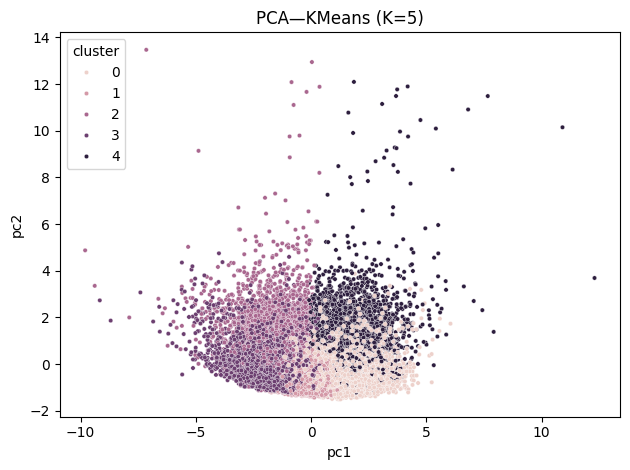

In [69]:
feat = ['pct_change_1','rsi','macd_diff','bb_width','bb_percent','atr','Volume']
data = df.dropna(subset=feat+['Timestamp','Close']).copy()
X = StandardScaler().fit_transform(data[feat])

# Cari K optimal (2..8)
scores = []
for k in range(2,9):
    km = KMeans(n_clusters=k, n_init=30, random_state=42)
    lab = km.fit_predict(X)
    scores.append((k, silhouette_score(X, lab)))
best_k = max(scores, key=lambda x: x[1])[0]

km = KMeans(n_clusters=best_k, n_init=50, random_state=42).fit(X)
data['cluster'] = km.labels_

# Profil klaster
prof = data.groupby('cluster')[feat+['future_pct_change']].mean().round(4)
print(prof)

# Viz 2D PCA
Xp = PCA(n_components=2, random_state=42).fit_transform(X)
viz = pd.DataFrame({'pc1':Xp[:,0],'pc2':Xp[:,1],'cluster':data['cluster'].values})
sns.scatterplot(data=viz, x='pc1', y='pc2', hue='cluster', s=10)
plt.title(f'PCA—KMeans (K={best_k})'); plt.tight_layout(); plt.show()
